In [9]:
import keras

from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras import regularizers
from keras import backend as K
import numpy as np

In [2]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
latent_dim=32

# this is our input placeholder
input_img = Input(shape=(784,))

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

In [4]:
# "encoded" is the encoded representation of the input
# DENSE VERSION:
#input_img = Input(shape=(784,))
#encoded = Dense(encoding_dim, activation='relu')(input_img)

# CONVOLUTIONAL VERSION:
input_img = Input(shape=(28,28,1))
x = layers.Conv2D(32, 3,padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
encoded = layers.Dense(32, activation='relu')(x)

In [5]:
z_mean = layers.Dense(latent_dim)(encoded)
z_log_var = layers.Dense(latent_dim)(encoded)
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [6]:
K.int_shape(input_img)[1:]

(28, 28, 1)

In [10]:
# "decoded" is the lossy reconstruction of the input
# DENSE VERSION:
#decoded = Dense(784, activation='sigmoid')(z) #(encoded)

# CONVOLUTIONAL VERSION:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same',activation='relu',strides=(2, 2))(x)
decoded = layers.Conv2D(1, 3,padding='same',activation='sigmoid')(x)

In [11]:
# this model maps an input to its reconstruction
decoder = Model(decoder_input, decoded)
z_decoded = decoder(z)
autoencoder = Model(input_img,z_decoded)

In [12]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]


# create the decoder model
decoder_vis = Model(encoded_input, decoder_layer(encoded_input))

In [13]:
def vae_loss(x, x_decoded_mean):
    xent_loss = keras.metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [14]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') #loss=vae_loss)#loss='binary_crossentropy')

In [15]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [16]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)
print(np.shape(x_train))

(60000, 28, 28, 1)


In [17]:
history = autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 2816/60000 [>.............................] - ETA: 14:23 - loss: 0.6541

KeyboardInterrupt: 

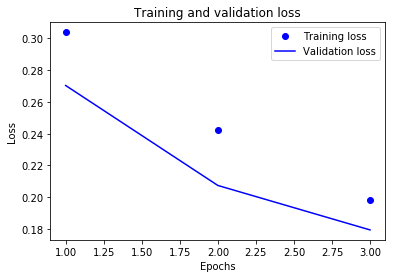

In [167]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, 6)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

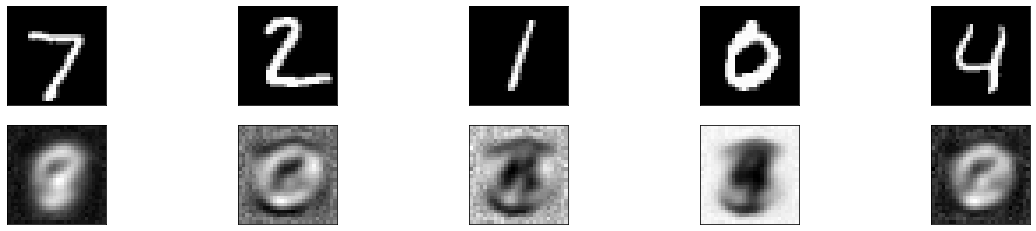

In [62]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()